# Prediction functions for U-net/LinkNet and MIL

This notebook shows how to make mask predictions and whole-image label predictions based on input ultrasound images. Currently this is implemented in two classes; `SegmentationEvaluator` and `AssessMILClassification`. Here we show how to use these two classes for prediction

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from wingspan_test.runner import SegmentationRunner, ClassificationRunner, bottom_crop, preprocess_img

## Load in data

This part will likely be different in your case as we are loading in pre-cropped images here just for illustration

In [3]:
datapath = '../009_01_wingspan/data/raw/mar_2018/processed/np_data_unique_split//'
imgs = np.load(f'{datapath}/imgs_test.npy')
masks = np.load(f'{datapath}/imgs_mask_test.npy')
ids = np.loadtxt(f'{datapath}/imgs_fname_test.txt', dtype=np.unicode)

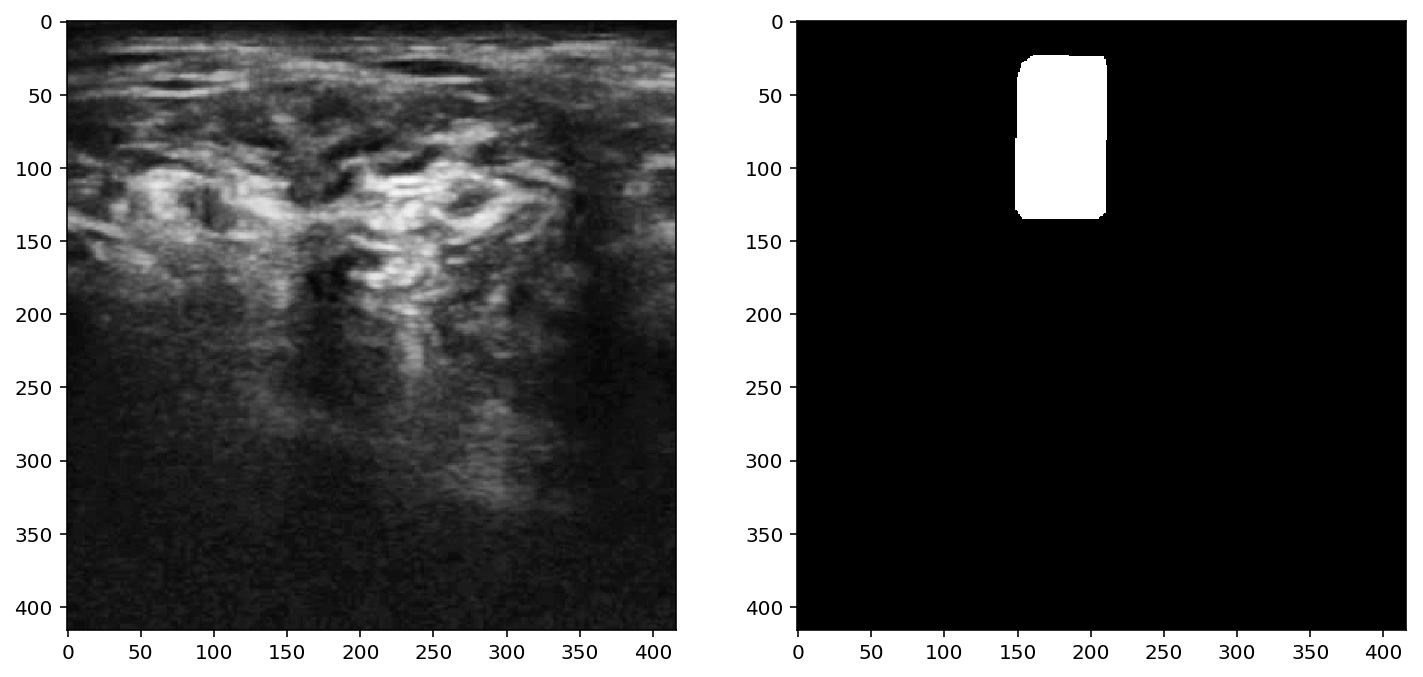

In [4]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.imshow(cv2.cvtColor(imgs[-8], cv2.COLOR_GRAY2BGR))

plt.subplot(122)
plt.imshow(cv2.cvtColor(masks[-8], cv2.COLOR_GRAY2BGR))

# Make mask predictions using U-net and LinkNet

The U-net model is based off of the architecture [here](https://arxiv.org/pdf/1505.04597.pdf) and the LinkNet architecture is based on [this](https://arxiv.org/pdf/1803.01207.pdf) paper. The implementation of the code is located in the `models.py` module. 

This model can be run using different image sizes. We have found that the original image size leads to slow performance and thus, we recommend using a smaller image size. Because of the network architecture the image size must be multiple of 32. The plot below shows the Dice score, classification accuracy (less important as final pipeline uses MIL as classifier), and runtime vs image size for the U-net and LinkNet models.

![](segmentation_timing.pdf)

We see that the evaluation time (on CPU) drops drastically with image size, while the Dice score only drops marginally. We also see that the evaluation time of LinkNet is much faster than U-net even though the LinkNet model has more parameters

## Load `SegmentationRunner` object

This constructor takes in 3 arguments. The first two are post-processing parameters that should not be changed and the third is `do_clahe` which will do CLAHE histogram equalization. Our training images have CLAHE normalization so if you are reading directly from the raw images, then you should set `do_clahe=True`

In [5]:
seg_model = SegmentationRunner()

## Load the model

This method will load the U-net or LinkNet model into memory. Its arguments are as follows

* **model**: This is either `unet` or `linknet`
* **dset**: This specifies which dataset was used to train the model. The options are `feb` or `mar`
* **img_size**: This is the target image size to which we will scale the original image.

In [6]:
# load model using image size 128 for march data using LinkNet
seg_model.load_model(model='linknet', dset='mar', img_size=128)

## Predict masks from images

This method expectsd an array of images. To run on a single image you can use `seg_model.predict_on_img`. Both methods take in the array of images and a boolean `post_process` indicating whether or not post-processing is done. If `post_process=False` predict will output an array of probability masks where each pixel has a probability of being in the nerve contour, otherwise we output an array of binary masks (1=nerve).


In [8]:
# Run on last 10 images in array
ypred = seg_model.predict(imgs[-10:])

Text(0.5,1,'Predicted Mask')

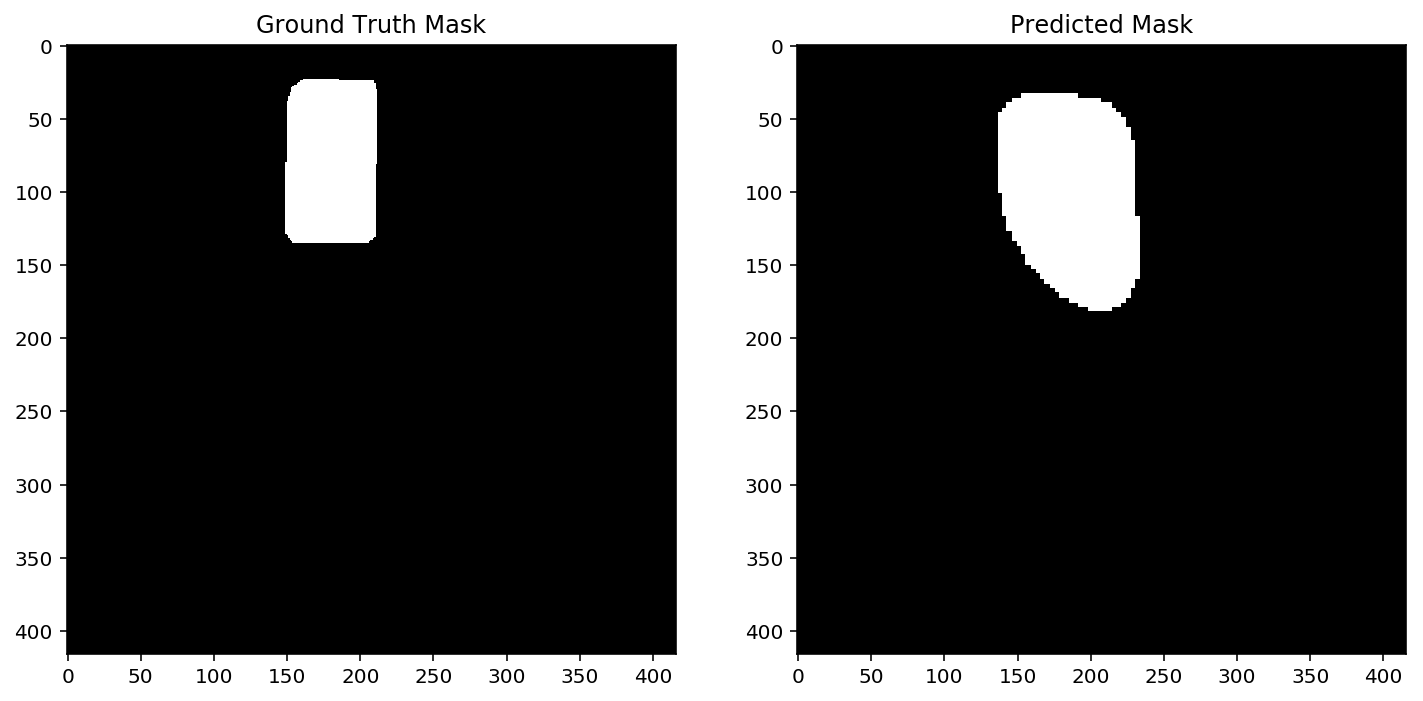

In [9]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.imshow(cv2.cvtColor(masks[-8], cv2.COLOR_GRAY2BGR))
plt.title('Ground Truth Mask')

plt.subplot(122)
plt.imshow(cv2.cvtColor(ypred[-8].astype(np.uint8)*255, cv2.COLOR_GRAY2BGR))
plt.title('Predicted Mask')

# Perform Classification with MIL

Here we will show how to use `ClassificationRunner` to perform whole-image classification using Multiple Instance Learning (MIL).

In a similar manner to the segmentation algorithm, this model can also be run with different image sizes and we can see from the graph above that it is much faster for smaller images.

## Load `ClassificationRunner` object

This constructor takes in an optional probability threshold argument, `thresh` and `do_clahe` as mentioned above.

In [10]:
mil_model = ClassificationRunner()

## Load the model

This method takes 2 arguments. 

* **img_size**: This is the target image size to which we will scale the original image.

In [11]:
# load model for march on full size dataset
mil_model.load_model(model='mil', dset='mar', img_size=416)

## Predict binary label on images

In a similar manner to the segmentation evaluator, this method expects an array of images.

In [12]:
# predict on the last 10 images
preds = mil_model.predict(imgs[-10:], post_process=False)

In [13]:
preds

array([0.99446458, 0.99019277, 0.9998616 , 0.99998081, 0.98850387,
       0.99975723, 0.99208647, 0.73125231, 0.99990487, 0.9999882 ])

In [15]:
# get labels for last 10 images
labels = np.array(np.sum(masks, axis=(1,2,3)) > 0, dtype=np.uint8)

# accuracy
acc = np.sum(np.round(preds) == labels[-10:]) / len(labels[-10:])
print(f'Accuracy: {acc}')

Accuracy: 1.0
